In [ ]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=0649db805c5535b77ed70e9c93d079e6ba598ea3aeff3a2477fd3bf85d353f46
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
!pip install spectral

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 3.7 MB/s eta 0:00:00


In [ ]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, GlobalAveragePooling2D, Multiply, Dense, Reshape, BatchNormalization, LSTM, Concatenate
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [ ]:
if not (os.path.isfile('Indian_pines_corrected.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
if not (os.path.isfile('Indian_pines_gt.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

#if not (os.path.isfile('/content/Salinas_corrected.mat')):
#  !wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_corrected.mat
#if not (os.path.isfile('/content/Salinas_gt.mat')):
#  !wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_gt.mat

--2024-05-19 08:23:25--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat [following]
--2024-05-19 08:23:25--  https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M  2.37MB/s    in 2.4s    

2024-05-19 08:23:28 (2.37 MB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

URL transformed to HTTPS due to an HSTS policy
--2024-05-19 08:23:28--  https://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.e

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


# Data Loading

In [ ]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.7
windowSize = 25

In [ ]:
def loadData(name):
    data_folder = '/content/drive/MyDrive/yapayZekaSistemleri/dataset'
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_folder, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_folder, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_folder, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_folder, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_folder, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_folder, 'PaviaU_gt.mat'))['paviaU_gt']

    return data, labels

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
X, y = loadData(dataset)

X.shape, y.shape

((145, 145, 200), (145, 145))

In [ ]:
K = X.shape[2]

In [ ]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 30)

In [ ]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3074, 25, 25, 30), (7175, 25, 25, 30), (3074,), (7175,))

# Model and Training

In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(3074, 25, 25, 30, 1)

In [ ]:
ytrain = keras.utils.to_categorical(ytrain)
ytrain.shape

(3074, 16)

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [ ]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [ ]:
# Giriş katmanı
input_layer = Input((S, S, L, 1))

# 3D Evrişim Katmanları (Spektral özellikler)
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)

# Yeniden Şekillendirme
conv3d_shape = conv_layer3.shape
reshaped_layer = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)

# Kanal Attention Modülü
attention = GlobalAveragePooling2D()(reshaped_layer)
attention = Dense(32, activation='relu')(attention)
attention = Dense(32, activation='relu')(attention)
attention = Dense(32, activation='sigmoid')(attention)
attention = Reshape((1, 1, 1, 32))(attention)
conv_layer3 = Multiply()([conv_layer3, attention])

# Mekansal özelliklerin işlenmesi için Conv2D katmanı
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

# Tam Bağlantılı Katmanlar
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)


In [ ]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 25, 30, 1)]      0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 23, 23, 24, 8)        512       ['input_1[0][0]']             
                                                                                                  
 conv3d_1 (Conv3D)           (None, 21, 21, 20, 16)       5776      ['conv3d[0][0]']              
                                                                                                  
 conv3d_2 (Conv3D)           (None, 19, 19, 18, 32)       13856     ['conv3d_1[0][0]']            
                                                                                              

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
# compiling the model
#adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# checkpoint
filepath = "/content/drive/MyDrive/yapayZekaSistemleri/indianpines/2d3dcnn-ipnopca.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
import time

start_time = time.time()
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)
end_time = time.time()


total_time = end_time - start_time
print(f'Toplam eğitim süresi: {total_time} saniye')

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 3.0604 - accuracy: 0.1057

13/13 [==============================] - 15s 188ms/step - loss: 3.0604 - accuracy: 0.1057
Epoch 2/100
12/13 [==========================>...] - ETA: 0s - loss: 2.5416 - accuracy: 0.1654

13/13 [==============================] - 2s 168ms/step - loss: 2.5416 - accuracy: 0.1653
Epoch 3/100
12/13 [==========================>...] - ETA: 0s - loss: 2.4202 - accuracy: 0.2070

13/13 [==============================] - 2s 167ms/step - loss: 2.4201 - accuracy: 0.2069
Epoch 4/100
12/13 [==========================>...] - ETA: 0s - loss: 2.0674 - accuracy: 0.3470

13/13 [==============================] - 2s 167ms/step - loss: 2.0664 - accuracy: 0.3474
Epoch 5/100
12/13 [==========================>...] - ETA: 0s - loss: 1.4055 - accuracy: 0.5560

13/13 [==============================] - 2s 168ms/step - loss: 1.4046 - accuracy: 0.5563
Epoch 6/100
12/13 [==========================>...] - ETA: 0s - loss: 0.8896 - accuracy: 0.7064

13/13 [==============================] - 2s 168ms/step - loss: 0.8890 - accuracy: 0.7066
Epoch 7/100
12/13 [==========================>...] - ETA: 0s - loss: 0.5469 - accuracy: 0.8216

13/13 [==============================] - 2s 168ms/step - loss: 0.5469 - accuracy: 0.8214
Epoch 8/100
12/13 [==========================>...] - ETA: 0s - loss: 0.4132 - accuracy: 0.8688

13/13 [==============================] - 2s 168ms/step - loss: 0.4137 - accuracy: 0.8686
Epoch 9/100
12/13 [==========================>...] - ETA: 0s - loss: 0.3642 - accuracy: 0.9014

13/13 [==============================] - 2s 168ms/step - loss: 0.3640 - accuracy: 0.9014
Epoch 10/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2237 - accuracy: 0.9284

13/13 [==============================] - 2s 168ms/step - loss: 0.2235 - accuracy: 0.9284
Epoch 11/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1753 - accuracy: 0.9417

13/13 [==============================] - 2s 168ms/step - loss: 0.1752 - accuracy: 0.9418
Epoch 12/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1400 - accuracy: 0.9561

13/13 [==============================] - 2s 168ms/step - loss: 0.1399 - accuracy: 0.9561
Epoch 13/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1231 - accuracy: 0.9609

13/13 [==============================] - 2s 168ms/step - loss: 0.1231 - accuracy: 0.9610
Epoch 14/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1003 - accuracy: 0.9701

13/13 [==============================] - 2s 168ms/step - loss: 0.1002 - accuracy: 0.9701
Epoch 15/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1056 - accuracy: 0.9720

13/13 [==============================] - 2s 168ms/step - loss: 0.1055 - accuracy: 0.9720
Epoch 16/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0966 - accuracy: 0.9694

13/13 [==============================] - 2s 168ms/step - loss: 0.0966 - accuracy: 0.9694
Epoch 17/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0642 - accuracy: 0.9772

13/13 [==============================] - 2s 169ms/step - loss: 0.0643 - accuracy: 0.9772
Epoch 18/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0803 - accuracy: 0.9753

13/13 [==============================] - 2s 169ms/step - loss: 0.0802 - accuracy: 0.9753
Epoch 19/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0870 - accuracy: 0.9743

13/13 [==============================] - 2s 169ms/step - loss: 0.0869 - accuracy: 0.9743
Epoch 20/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0596 - accuracy: 0.9782

13/13 [==============================] - 2s 169ms/step - loss: 0.0595 - accuracy: 0.9782
Epoch 21/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0643 - accuracy: 0.9808

13/13 [==============================] - 2s 169ms/step - loss: 0.0642 - accuracy: 0.9808
Epoch 22/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0527 - accuracy: 0.9834

13/13 [==============================] - 2s 170ms/step - loss: 0.0527 - accuracy: 0.9834
Epoch 23/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0431 - accuracy: 0.9860

13/13 [==============================] - 2s 170ms/step - loss: 0.0431 - accuracy: 0.9860
Epoch 24/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0439 - accuracy: 0.9837

13/13 [==============================] - 2s 169ms/step - loss: 0.0439 - accuracy: 0.9837
Epoch 25/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0392 - accuracy: 0.9873

13/13 [==============================] - 2s 170ms/step - loss: 0.0392 - accuracy: 0.9873
Epoch 26/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0288 - accuracy: 0.9889

13/13 [==============================] - 2s 169ms/step - loss: 0.0287 - accuracy: 0.9889
Epoch 27/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0319 - accuracy: 0.9909

13/13 [==============================] - 2s 170ms/step - loss: 0.0319 - accuracy: 0.9909
Epoch 28/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0313 - accuracy: 0.9902

13/13 [==============================] - 2s 170ms/step - loss: 0.0313 - accuracy: 0.9902
Epoch 29/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0294 - accuracy: 0.9880

13/13 [==============================] - 2s 170ms/step - loss: 0.0294 - accuracy: 0.9880
Epoch 30/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0304 - accuracy: 0.9902

13/13 [==============================] - 2s 169ms/step - loss: 0.0304 - accuracy: 0.9902
Epoch 31/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0332 - accuracy: 0.9915

13/13 [==============================] - 2s 170ms/step - loss: 0.0331 - accuracy: 0.9915
Epoch 32/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0302 - accuracy: 0.9909

13/13 [==============================] - 2s 170ms/step - loss: 0.0302 - accuracy: 0.9909
Epoch 33/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0234 - accuracy: 0.9928

13/13 [==============================] - 2s 170ms/step - loss: 0.0234 - accuracy: 0.9928
Epoch 34/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0268 - accuracy: 0.9899

13/13 [==============================] - 2s 170ms/step - loss: 0.0268 - accuracy: 0.9899
Epoch 35/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0296 - accuracy: 0.9906

13/13 [==============================] - 2s 170ms/step - loss: 0.0296 - accuracy: 0.9906
Epoch 36/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0205 - accuracy: 0.9935

13/13 [==============================] - 2s 171ms/step - loss: 0.0205 - accuracy: 0.9935
Epoch 37/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0209 - accuracy: 0.9941

13/13 [==============================] - 2s 170ms/step - loss: 0.0209 - accuracy: 0.9941
Epoch 38/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0235 - accuracy: 0.9915

13/13 [==============================] - 2s 171ms/step - loss: 0.0235 - accuracy: 0.9915
Epoch 39/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0348 - accuracy: 0.9902

13/13 [==============================] - 2s 170ms/step - loss: 0.0348 - accuracy: 0.9902
Epoch 40/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0203 - accuracy: 0.9941

13/13 [==============================] - 2s 171ms/step - loss: 0.0203 - accuracy: 0.9941
Epoch 41/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0164 - accuracy: 0.9941

13/13 [==============================] - 2s 171ms/step - loss: 0.0164 - accuracy: 0.9941
Epoch 42/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0128 - accuracy: 0.9967

13/13 [==============================] - 2s 170ms/step - loss: 0.0128 - accuracy: 0.9967
Epoch 43/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0146 - accuracy: 0.9948

13/13 [==============================] - 2s 171ms/step - loss: 0.0146 - accuracy: 0.9948
Epoch 44/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0236 - accuracy: 0.9912

13/13 [==============================] - 2s 171ms/step - loss: 0.0236 - accuracy: 0.9912
Epoch 45/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0143 - accuracy: 0.9948

13/13 [==============================] - 2s 171ms/step - loss: 0.0143 - accuracy: 0.9948
Epoch 46/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0273 - accuracy: 0.9902

13/13 [==============================] - 2s 172ms/step - loss: 0.0273 - accuracy: 0.9902
Epoch 47/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0102 - accuracy: 0.9971

13/13 [==============================] - 2s 172ms/step - loss: 0.0102 - accuracy: 0.9971
Epoch 48/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0149 - accuracy: 0.9954

13/13 [==============================] - 2s 171ms/step - loss: 0.0149 - accuracy: 0.9954
Epoch 49/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0133 - accuracy: 0.9941

13/13 [==============================] - 2s 171ms/step - loss: 0.0133 - accuracy: 0.9941
Epoch 50/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0227 - accuracy: 0.9922

13/13 [==============================] - 2s 172ms/step - loss: 0.0226 - accuracy: 0.9922
Epoch 51/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0146 - accuracy: 0.9938

13/13 [==============================] - 2s 171ms/step - loss: 0.0146 - accuracy: 0.9938
Epoch 52/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0209 - accuracy: 0.9935

13/13 [==============================] - 2s 173ms/step - loss: 0.0209 - accuracy: 0.9935
Epoch 53/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0179 - accuracy: 0.9922

13/13 [==============================] - 2s 172ms/step - loss: 0.0179 - accuracy: 0.9922
Epoch 54/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0176 - accuracy: 0.9951

13/13 [==============================] - 2s 172ms/step - loss: 0.0176 - accuracy: 0.9951
Epoch 55/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0154 - accuracy: 0.9938

13/13 [==============================] - 2s 172ms/step - loss: 0.0153 - accuracy: 0.9938
Epoch 56/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0155 - accuracy: 0.9948

13/13 [==============================] - 2s 172ms/step - loss: 0.0155 - accuracy: 0.9948
Epoch 57/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0154 - accuracy: 0.9971

13/13 [==============================] - 2s 172ms/step - loss: 0.0154 - accuracy: 0.9971
Epoch 58/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0132 - accuracy: 0.9961

13/13 [==============================] - 2s 173ms/step - loss: 0.0132 - accuracy: 0.9961
Epoch 59/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0126 - accuracy: 0.9945

13/13 [==============================] - 2s 172ms/step - loss: 0.0126 - accuracy: 0.9945
Epoch 60/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0113 - accuracy: 0.9967

13/13 [==============================] - 2s 173ms/step - loss: 0.0113 - accuracy: 0.9967
Epoch 61/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0131 - accuracy: 0.9974

13/13 [==============================] - 2s 173ms/step - loss: 0.0131 - accuracy: 0.9974
Epoch 62/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0144 - accuracy: 0.9958

13/13 [==============================] - 2s 173ms/step - loss: 0.0143 - accuracy: 0.9958
Epoch 63/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0133 - accuracy: 0.9958

13/13 [==============================] - 2s 172ms/step - loss: 0.0132 - accuracy: 0.9958
Epoch 64/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0109 - accuracy: 0.9977

13/13 [==============================] - 2s 173ms/step - loss: 0.0109 - accuracy: 0.9977
Epoch 65/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0128 - accuracy: 0.9971

13/13 [==============================] - 2s 174ms/step - loss: 0.0127 - accuracy: 0.9971
Epoch 66/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0131 - accuracy: 0.9951

13/13 [==============================] - 2s 172ms/step - loss: 0.0131 - accuracy: 0.9951
Epoch 67/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0171 - accuracy: 0.9964

13/13 [==============================] - 2s 173ms/step - loss: 0.0171 - accuracy: 0.9964
Epoch 68/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0083 - accuracy: 0.9984

13/13 [==============================] - 2s 172ms/step - loss: 0.0083 - accuracy: 0.9984
Epoch 69/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0143 - accuracy: 0.9961

13/13 [==============================] - 2s 173ms/step - loss: 0.0143 - accuracy: 0.9961
Epoch 70/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0080 - accuracy: 0.9964

13/13 [==============================] - 2s 173ms/step - loss: 0.0080 - accuracy: 0.9964
Epoch 71/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0107 - accuracy: 0.9974

13/13 [==============================] - 2s 173ms/step - loss: 0.0107 - accuracy: 0.9974
Epoch 72/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0074 - accuracy: 0.9971

13/13 [==============================] - 2s 173ms/step - loss: 0.0074 - accuracy: 0.9971
Epoch 73/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0159 - accuracy: 0.9964

13/13 [==============================] - 2s 173ms/step - loss: 0.0159 - accuracy: 0.9964
Epoch 74/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0127 - accuracy: 0.9961

13/13 [==============================] - 2s 173ms/step - loss: 0.0127 - accuracy: 0.9961
Epoch 75/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0197 - accuracy: 0.9941

13/13 [==============================] - 2s 173ms/step - loss: 0.0197 - accuracy: 0.9941
Epoch 76/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0085 - accuracy: 0.9971

13/13 [==============================] - 2s 173ms/step - loss: 0.0085 - accuracy: 0.9971
Epoch 77/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0139 - accuracy: 0.9967

13/13 [==============================] - 2s 173ms/step - loss: 0.0139 - accuracy: 0.9967
Epoch 78/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0114 - accuracy: 0.9971

13/13 [==============================] - 2s 173ms/step - loss: 0.0114 - accuracy: 0.9971
Epoch 79/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0116 - accuracy: 0.9964

13/13 [==============================] - 2s 173ms/step - loss: 0.0116 - accuracy: 0.9964
Epoch 80/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0142 - accuracy: 0.9958

13/13 [==============================] - 2s 173ms/step - loss: 0.0142 - accuracy: 0.9958
Epoch 81/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0080 - accuracy: 0.9964

13/13 [==============================] - 2s 173ms/step - loss: 0.0080 - accuracy: 0.9964
Epoch 82/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0118 - accuracy: 0.9958

13/13 [==============================] - 2s 173ms/step - loss: 0.0118 - accuracy: 0.9958
Epoch 83/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0185 - accuracy: 0.9948

13/13 [==============================] - 2s 173ms/step - loss: 0.0185 - accuracy: 0.9948
Epoch 84/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0099 - accuracy: 0.9961

13/13 [==============================] - 2s 173ms/step - loss: 0.0099 - accuracy: 0.9961
Epoch 85/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0135 - accuracy: 0.9961

13/13 [==============================] - 2s 173ms/step - loss: 0.0135 - accuracy: 0.9961
Epoch 86/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0080 - accuracy: 0.9967

13/13 [==============================] - 2s 173ms/step - loss: 0.0080 - accuracy: 0.9967
Epoch 87/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0110 - accuracy: 0.9964

13/13 [==============================] - 2s 173ms/step - loss: 0.0110 - accuracy: 0.9964
Epoch 88/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0076 - accuracy: 0.9961

13/13 [==============================] - 2s 173ms/step - loss: 0.0076 - accuracy: 0.9961
Epoch 89/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0058 - accuracy: 0.9974

13/13 [==============================] - 2s 172ms/step - loss: 0.0058 - accuracy: 0.9974
Epoch 90/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0048 - accuracy: 0.9984

13/13 [==============================] - 2s 172ms/step - loss: 0.0048 - accuracy: 0.9984
Epoch 91/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0031 - accuracy: 0.9990

13/13 [==============================] - 2s 172ms/step - loss: 0.0031 - accuracy: 0.9990
Epoch 92/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0098 - accuracy: 0.9974

13/13 [==============================] - 2s 173ms/step - loss: 0.0098 - accuracy: 0.9974
Epoch 93/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0110 - accuracy: 0.9951

13/13 [==============================] - 2s 173ms/step - loss: 0.0110 - accuracy: 0.9951
Epoch 94/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0095 - accuracy: 0.9977

13/13 [==============================] - 2s 172ms/step - loss: 0.0095 - accuracy: 0.9977
Epoch 95/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0143 - accuracy: 0.9954

13/13 [==============================] - 2s 172ms/step - loss: 0.0143 - accuracy: 0.9954
Epoch 96/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0228 - accuracy: 0.9941

13/13 [==============================] - 2s 172ms/step - loss: 0.0228 - accuracy: 0.9941
Epoch 97/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0191 - accuracy: 0.9941

13/13 [==============================] - 2s 172ms/step - loss: 0.0191 - accuracy: 0.9941
Epoch 98/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0134 - accuracy: 0.9964

13/13 [==============================] - 2s 172ms/step - loss: 0.0134 - accuracy: 0.9964
Epoch 99/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0243 - accuracy: 0.9928

13/13 [==============================] - 2s 172ms/step - loss: 0.0243 - accuracy: 0.9928
Epoch 100/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0278 - accuracy: 0.9925

13/13 [==============================] - 2s 172ms/step - loss: 0.0278 - accuracy: 0.9925
Toplam eğitim süresi: 237.16639375686646 saniye


In [ ]:
model.save("/content/drive/MyDrive/yapayZekaSistemleri/indianpines/2d3dcnn-ipnopca.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



# Validation

In [ ]:
# load best weights
model.load_weights("/content/drive/MyDrive/yapayZekaSistemleri/indianpines/2d3dcnn-ipnopca.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(7175, 25, 25, 30, 1)

In [ ]:
ytest = keras.utils.to_categorical(ytest)
ytest.shape

(7175, 16)

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

225/225 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       0.99      1.00      1.00      1000
           2       0.99      0.99      0.99       581
           3       0.99      1.00      1.00       166
           4       0.99      1.00      0.99       338
           5       1.00      1.00      1.00       511
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00       335
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00       680
          10       1.00      1.00      1.00      1719
          11       1.00      0.98      0.99       415
          12       1.00      1.00      1.00       143
          13       1.00      1.00      1.00       886
          14       0.99      1.00      1.00       270
          15       0.98      1.00      0.99        65

    accuracy             

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "/content/drive/MyDrive/yapayZekaSistemleri/indianpines/classification_reportnopca.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

225/225 [==============================] - 2s 6ms/step - loss: 0.0120 - accuracy: 0.9972


In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [ ]:
# load the original image
X, y = loadData(dataset)

In [ ]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [ ]:
X,pca = applyPCA(X, numComponents=numComponents)

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
start_time = time.time()

# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1


end_time = time.time()


total_test_time = end_time - start_time
print(f'Toplam test süresi: {total_test_time} saniye')

1/1 [==============================] - 0s 20ms/step


<ipython-input-40-72d3acf300c7>:15: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Görüntülenen çıkış son 5000 satıra kısaltıldı.
1/1 [==============================] - 0s 21ms/step
Toplam test süresi: 660.4921119213104 saniye


/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



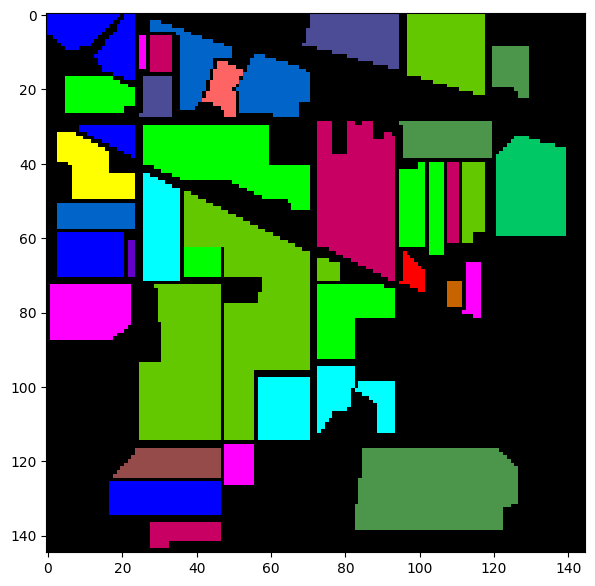

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

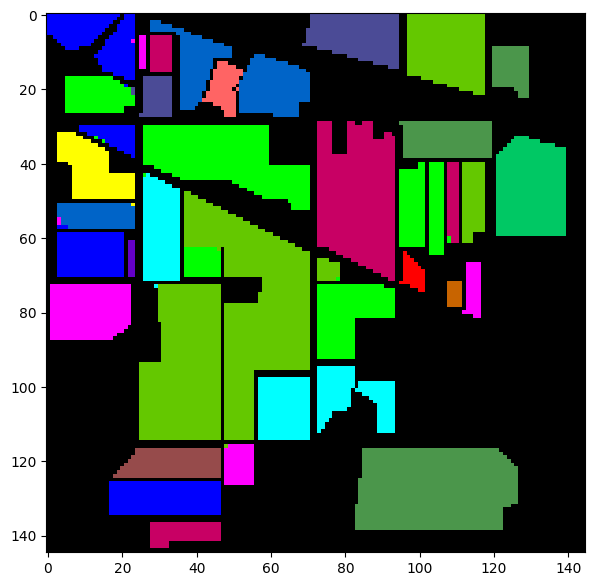

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [ ]:
spectral.save_rgb("predictionsnopca.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)